# CS 363M Project Group 14
Names: Ruchi Bhalani, Anthony Modica, Martin Nguyen, Lindsey Smyth

# Introduction
Crime has always been a difficult problem to solve. According to the Pew Research Center in 2017, fewer than half of all crimes are reported, and fewer than half of those have been solved (https://www.pewresearch.org/fact-tank/2017/03/01/most-violent-and-property-crimes-in-the-u-s-go-unsolved/). There are many factors that are involved in solving a crime, but many cases can be unsolved due to things such as insufficient evidence and time taken. 

What we are trying to solve here is **given the factors of a certain crime, will the crime be able to be cleared or not**? This is important since there are only so many police officers and detectives that can be assigned to a case at a time, and sometimes it might not be worth the effort on certain types of crimes that are categorized as misdemeanors. Although officers should not fully take the results of the model to be true, perhaps they could reconsider how much manpower they are assigning to each specific case and how long they should stay on them. This way, more crimes could potentially be cleared by allocating officers’ time wisely.

# Dataset
We are using Austin Police Department’s (APD) Crime Reports dataset (https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu). This dataset contains all incidents that APD has responded to and made a report since 2003. Due to the dataset being updated weekly and reports from long ago are constantly being added to the database weekly, we decided to use only **reports made before and including the update on November 7th, which contain 2.34 million records**.

Each record contains **27 features**, which includes the incident report number, the crime reported, the dates the crime and report were occurred and made respectively, the location, and whether the crime has been solved. We will be using models to **predict whether a crime has been cleared by either an arrest or by exception**, which are denoted as `C` and `O` respectively on the dataset. A crime is not cleared if there is an `N` or a blank in the clearance status column.

# Data Prep
Since uploading and training a model on 2.34 million records is not suitable, we decided to only use records that had reports filed in 2021. That way we are able to see an entire year’s worth of reports in a recent enough year that we can make predictions on. As a result, the 2021 partition of the dataset gives us **91,500 records**, which should be enough to train on with our models. 

There are also many rows that have some features blank, notably the clearance status column. We decided to drop all rows that contained a blank feature that we are using, since using imputation or another method could potentially affect the status of the reports made, which results in about **33,500 records**.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# We all had the data stored in the exact spot in our Google Drives, enabling us to upload the same data.
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML final project/Crime_Reports.csv", header='infer')
print("Number of rows for 2021 reports:", data.shape)
data.dropna(inplace = True)
print("Number of rows that have no NaNs:", data.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of rows for 2021 reports: (91500, 27)
Number of rows that have no NaNs: (33597, 27)


# Data Exploration
Here we are looking to see if there are certain trends within the data.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

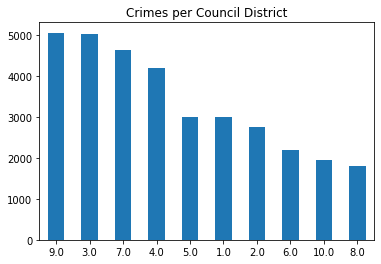

In [ ]:
fig, axs = plt. subplots()
data['Council District'].value_counts().plot(kind='bar')
axs.set_title("Crimes per Council District")
plt.xticks(rotation = 'horizontal')

It seems that the most popular crimes reported in 2021 were different forms of theft. The only category in the top 10 that is not a form of theft is aggravated assault.

Text(0.5, 1.0, 'Top 10 Crimes Committed in 2021')

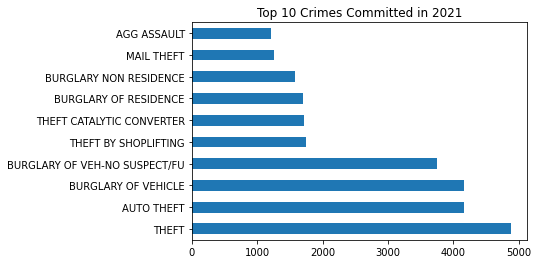

In [ ]:
fig, axs = plt.subplots()
data['Highest Offense Description'].value_counts().head(10).plot(kind='barh')
axs.set_title("Top 10 Crimes Committed in 2021")

Text(0.5, 1.0, 'Top 10 Days Crimes Occurred in 2021')

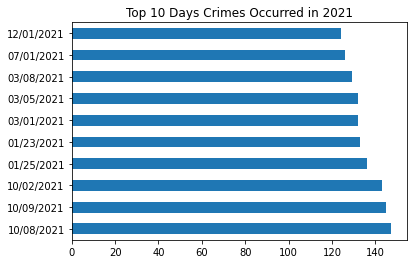

In [ ]:
fig, axs = plt.subplots()
data['Occurred Date'].value_counts().head(10).plot(kind='barh')
axs.set_title("Top 10 Days Crimes Occurred in 2021")

The number of crimes cleared by either arrest or exception (`C` or `O`) are low compared to non-cleared crimes. This means that we will either have to upscale or downscale our data in order to train our models properly.

N    30298
C     3245
O       54
Name: Clearance Status, dtype: int64


Text(0.5, 1.0, 'Percentage of Crimes Cleared')

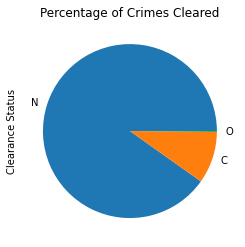

In [ ]:
print(data['Clearance Status'].value_counts())
fig, axs = plt.subplots()
data['Clearance Status'].value_counts().plot(kind='pie')
axs.set_title("Percentage of Crimes Cleared")

# Feature Engineering

We decided to drop 13 columns, which is almost half of the features available. The reason we decided to drop these 13 columns is that many of them were duplicates, extraneous, or another way to express another feature. Some notable features dropped include date time (which was a combined feature of two other features), address, and other location features such as APD sector.

Since both `C` and `O` mean the same thing, we will transform the `O` values to `C` in order to have a two class problem. Since there is also a class imbalance, we will downsample by randomly selecting noncleared crimes in order to make them equal.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Features removed: Incident number, Highest offense code, Occurred date time, Report date time, address,
# Council district, APD Sector, PRA, Census Tract, UCR Category, Category Description, X-coordinate, Y-coordinate, Location
data = data.drop(columns = ['Incident Number', 'Highest Offense Code', 'Occurred Date Time', 'Report Date Time', 'Address', 'APD Sector', 'PRA', 'Census Tract', 'UCR Category', 'Category Description', 'X-coordinate', 'Y-coordinate', 'Location'])


# Having negatives can be finnicky such as with Naive Bayes, doesn't matter in the long run since they're all near the same location.
data['Longitude'] = data['Longitude'].apply(lambda x : x * -1)

# Replacing Os with Cs
data.replace({'Clearance Status': 'O'}, 'C', inplace=True)

# Categorize all non-numeric columns
objList = data.select_dtypes(include = "object").columns
le = LabelEncoder()
for feat in objList:
  data[feat] = le.fit_transform(data[feat].astype(str))

# Downsampling
full_data = data.copy()
full_labels = full_data['Clearance Status'].values.ravel()
full_data = full_data.drop('Clearance Status', axis = 1)
cleared = data.loc[data['Clearance Status'] == 0]
noncleared_sample = data.loc[data['Clearance Status'] == 1].sample(n = len(cleared))
data = pd.concat([cleared, noncleared_sample])

# We don't want to categorize the variables yet for linear regression!
regression_data = data.copy()

# Getting array of labels and removing clearance status from the data
labels = data.filter(['Clearance Status'], axis = 1)
data = data.drop('Clearance Status', axis = 1)
labels_array = labels.values.ravel()

data.head()
print(data.shape)

(6598, 13)


# Modeling

Since each model might require manipulating the data in different ways, before each model we will copy the dataframe and make modifications depending on the requirements. This way we can preserve the original sampled data. Since our data is labeled we will try a variety of supervised classification algorithms on our dataset.

# Decision Tree

Using a decision tree model is very interesting given the fact that all of the dates are being categorized, resulting in not being able to be used as a range. This might have contributed to the low accuracy of the model, but ~50% is alright given the circumstances.

The average accuracy is chosen from the nested cross-validation method utilized in Assignment 4. We've decided to choose a couple of parameters instead of a range in order to calculate the models faster.

13 is the max number of features, which is why the last number in `max_features` is not 15.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

decision_tree = DecisionTreeClassifier(criterion = "gini", random_state = 5)

param_grid = {
    'max_depth': [5, 10, 15, 20],
    'max_features': [5, 10, 13],
    'min_samples_leaf': [5, 10, 15, 20]
}

grid_search = GridSearchCV(decision_tree, param_grid, scoring = 'accuracy')
decision_accuracies = cross_val_score(grid_search, data, labels_array, cv = 5)
decision_accuracy = sum(decision_accuracies) / len(decision_accuracies)
print(decision_accuracy)
predictions = cross_val_predict(grid_search, data, labels_array, cv = 5)
dt_cm = confusion_matrix(labels_array, predictions)
dt_cr = classification_report(labels_array, predictions,  target_names = ['Cleared', 'Not Cleared'])

0.49621166172720377


In [ ]:
print(dt_cm)
print(dt_cr)

[[ 989 2310]
 [1014 2285]]
              precision    recall  f1-score   support

           0       0.49      0.30      0.37      3299
           1       0.50      0.69      0.58      3299

    accuracy                           0.50      6598
   macro avg       0.50      0.50      0.48      6598
weighted avg       0.50      0.50      0.48      6598



# Naïve Bayes
We wanted to experiment with Naive Bayes since its a fast and simple algorithm. This is because probabilities can be calculated with a single scan of the data, as opposed to a more lengthy iterative processing of the data. Furthermore Naive Bayes does not suffer from the curse of dimensionality and because of this, we wont run pca on the features even though this data set has a fair number of features. One of the downsides however is that it assumes that the input features are statistically independent from eachother which is likely not the case given that the features Council District and APD district are likely related. However given the ~75% f1-scores it looks like the features were independent enough.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import CategoricalNB

clf = CategoricalNB()
cv = KFold(5, shuffle=True, random_state=33)
accuracies = cross_val_score(clf, data, labels_array, cv=cv)
print("avg. accuracy: {}".format(accuracies.mean()))
predictions = cross_val_predict(clf, data, labels_array, cv = cv)
nb_cm = confusion_matrix(labels_array, predictions)
nb_cr = classification_report(labels_array, predictions,  target_names = ['Cleared', 'Not Cleared'])
print(nb_cm)
print(nb_cr)
#call fit on the model to use later
clf.fit(data, labels_array)

avg. accuracy: 0.7570418361017299
[[2334  965]
 [ 638 2661]]
              precision    recall  f1-score   support

           0       0.79      0.71      0.74      3299
           1       0.73      0.81      0.77      3299

    accuracy                           0.76      6598
   macro avg       0.76      0.76      0.76      6598
weighted avg       0.76      0.76      0.76      6598



CategoricalNB()

## Multiple Linear Regression

**Data Prep**

We need to make sure to use the unencoded values since we need to create dummies in order to utilize multiple linear regression with the categorical variables.

In [ ]:
regression_data = pd.get_dummies(regression_data, drop_first = False)
regression_data.head()

,Highest Offense Description,Family Violence,Occurred Date,Occurred Time,Report Date,Report Time,Location Type,Zip Code,Council District,APD District,Clearance Status,Clearance Date,Latitude,Longitude
52,13,0,0,1430,0,1441,28,78704.0,3.0,1,0,5,30.226533,97.762518
105,35,0,0,1640,0,1644,30,78745.0,2.0,2,0,0,30.190612,97.772294
115,34,0,0,858,0,858,23,78701.0,9.0,3,0,24,30.265837,97.746501
124,3,0,0,306,0,306,30,78757.0,7.0,5,0,0,30.366942,97.728403
182,3,0,0,100,0,352,7,78701.0,9.0,1,0,7,30.266763,97.739077


Given the fact that there are many categorical variables (at least 365 dates), printing the correlation for each one will be a bit too much.

We want to test if we can predict the clearance status of a reported crime using a multiple linear regression model.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

x_train, x_test, y_train, y_test = train_test_split(regression_data, labels_array, test_size=0.2, random_state=40)
reg = LinearRegression().fit(x_train, y_train)

all_scores = cross_val_score(reg, regression_data, labels_array, cv=5)
total = 0.0
print(all_scores)
for r in all_scores:
  total += r
print('generalization estimate: ', total/(len(all_scores)))

[0. 0. 1. 0. 0.]
generalization estimate:  0.2


Even though linear correlation is low, here we can build the final model on the entire dataset.

In [ ]:
reg4 = LinearRegression().fit(regression_data, labels_array)
print(reg4.coef_)
print(reg4.intercept_)

reg_accuracies = cross_val_score(reg4, regression_data, labels_array, cv=5)
print("avg. accuracy: {}".format(reg_accuracies.mean()))
reg_predictions = cross_val_predict(reg4, regression_data, labels_array, cv = 5)

[ 1.21243118e-17 -1.25854188e-15  4.66206934e-17  2.81892565e-18
 -3.69712941e-17 -6.93889390e-18  8.92027337e-17 -1.13590506e-16
 -3.70824248e-16  5.62231502e-15  1.00000000e+00  1.40946282e-17
  8.34883980e-18  1.03204082e-17]
8.929079697850284e-12
avg. accuracy: 0.2


Since you cannot compute a confusion matrix over continuous values and the accuracy is fairly low anyways, we can stop here rather than attempting to determine a cuttoff value to classify the linear regression predictions.

# KNN

Now, we are going to try using KNN to predict values. Since we need numerical data, we will go back to the label encoded values we had before.

Now we can see if we can predict the clearance status of a reported crime based on the label encoded features and a KNN model. We need to find the best value for `k` to base a prediction off of.

In [ ]:
from pandas.core.arrays.string_arrow import pc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import statistics

best_mean = 0
best_k = 0
cv_score_saved = []
for k in range(2, 26):
  scaler = StandardScaler()
  knn = KNeighborsClassifier(k)
  pca = PCA()
  pipeline = Pipeline([('scaler', scaler), ('pca', pca), ('knn', knn)])
  cv_score = cross_val_score(pipeline, data, labels_array, cv=5)
  mean = statistics.mean(cv_score)
  print("k = ", k, " mean: ", mean)
  if mean > best_mean:
    best_mean = mean
    best_k = k
    cv_score_saved = cv_score

print("\n", best_k)
print(best_mean)

k =  2  mean:  0.5862402646633125
k =  3  mean:  0.5977588623153445
k =  4  mean:  0.5962430215728168
k =  5  mean:  0.6074598525053415
k =  6  mean:  0.6042743584441841
k =  7  mean:  0.6117027362326831
k =  8  mean:  0.6018525283157581
k =  9  mean:  0.6089736255657408
k =  10  mean:  0.6047305120959404
k =  11  mean:  0.6051858616490914
k =  12  mean:  0.6077625381946837
k =  13  mean:  0.6103390998690468
k =  14  mean:  0.6083691731568911
k =  15  mean:  0.6135217221494704
k =  16  mean:  0.6112492246192018
k =  17  mean:  0.6107931858386748
k =  18  mean:  0.6074597376341122
k =  19  mean:  0.6120057665357135
k =  20  mean:  0.6101885036873664
k =  21  mean:  0.6145826728237646
k =  22  mean:  0.6095824430813058
k =  23  mean:  0.6074595078916535
k =  24  mean:  0.6080663725963196
k =  25  mean:  0.6060944930732649

 21
0.6145826728237646


We can now compute a confusion matrix based on the best k value.

In [ ]:
print("avg. accuracy: {}".format(cv_score_saved.mean()))
knn = KNeighborsClassifier(best_k)
knn_preds = cross_val_predict(knn, data, labels_array, cv = 5)
knn_cm = confusion_matrix(labels_array, knn_preds)
knn_cr = classification_report(labels_array, knn_preds,  target_names = ['Cleared', 'Not Cleared'])

print(knn_cm)
print(knn_cr)

knn.fit(data, labels_array)

avg. accuracy: 0.6145826728237646
[[1272 2027]
 [1157 2142]]
              precision    recall  f1-score   support

           0       0.52      0.39      0.44      3299
           1       0.51      0.65      0.57      3299

    accuracy                           0.52      6598
   macro avg       0.52      0.52      0.51      6598
weighted avg       0.52      0.52      0.51      6598



KNeighborsClassifier(n_neighbors=21)

# Neural Networks
Scikit-Learn's MLP classifier will try a number of hidden layers and a variety of activation functions to fit to the data. It will also iteratively perform back propogation on its own in order to find the correct weights to fit to the data.

In [ ]:
from sklearn.neural_network import MLPClassifier

scores = cross_val_score(MLPClassifier(), data, labels_array, cv=5)
print("Accuracy: ", sum(scores) / len(scores))
predictions = cross_val_predict(MLPClassifier(), data, labels_array, cv = 5)
nn_cm = confusion_matrix(labels_array, predictions)
nn_cr = classification_report(labels_array, predictions,  target_names = ['Cleared', 'Not Cleared'])
print(nn_cm)
print(nn_cr)

Accuracy:  0.505749190157833
[[1234 2065]
 [1138 2161]]
              precision    recall  f1-score   support

           0       0.52      0.37      0.44      3299
           1       0.51      0.66      0.57      3299

    accuracy                           0.51      6598
   macro avg       0.52      0.51      0.50      6598
weighted avg       0.52      0.51      0.50      6598



# Results

We will now try our KNN and Naive Bayes classification models on the entire data set since these were the only models significantly above 50% average accuracy on our downsampled data set.

In [ ]:
predicted_labels = clf.predict(full_data)
final_cr = classification_report(full_labels, predicted_labels,  target_names = ['Cleared', 'Not Cleared'])
print(final_cr)

predicted_labels_knn = knn.predict(full_data)
final_cr_knn = classification_report(full_labels, predicted_labels_knn, target_names = ['Cleared', 'Not Cleared'])
print(final_cr_knn)


              precision    recall  f1-score   support

     Cleared       0.32      0.82      0.46      3299
 Not Cleared       0.98      0.81      0.89     30298

    accuracy                           0.81     33597
   macro avg       0.65      0.82      0.67     33597
weighted avg       0.91      0.81      0.85     33597

              precision    recall  f1-score   support

     Cleared       0.19      0.82      0.31      3299
 Not Cleared       0.97      0.63      0.76     30298

    accuracy                           0.65     33597
   macro avg       0.58      0.73      0.54     33597
weighted avg       0.89      0.65      0.72     33597



# Conclusion
Unfortunately it looks like our model is not very accurate for predicting records that were cleared. This probably has to do with the the fact that there is a disproportionate amount of records that were not cleared compared to records that were cleared. This initially resulted in accuracies around 90% for every model, because each classifier could simply predict not cleared. We tried to account for this by downsampling, in order to have an even amount of each label. On the downsampled data, we were able to achieve reasonable results for most classifiers, but after running the best classifiers on the whole dataset, based on low F-scores and other metrics, it looks as if that did not sufficiently solve the problem. 